# Getting Started

<a name='contents'></a>
## Contents

1. <a href='#magic'>The <tt>matmodlab</tt> namespace</a>
1. <a href='#model.def'>Defining a Model</a>
   1. <a href='#model.def.mat'>Material Model Definition</a>
   2. <a href='#model.def.step'>Step Definitions</a>
2. <a href='#model.run'>Running a Model</a>
3. <a href='#model.out'>Model Outputs</a>
4. <a href='#model.view'>Viewing Model Results</a>

<a name='magic'></a>
## The matmodlab Namespace

A notebook should include the following statement to import the Matmodlab namespace

    from matmodlab2 import *

In [1]:
%pylab inline
from matmodlab2 import *

Populating the interactive namespace from numpy and matplotlib
Setting up the Matmodlab notebook environment


<a name='model.def'></a>
## Defining a Model

The purpose of a Matmodlab model is to predict the response of a material to deformation.  A Matmodlab model requires two parts to be fully defined: 

- *Material* model: the material type and associated parameters.
- Deformation *step[s]*: defines deformation paths through which the material model is exercised.

The `MaterialPointSimulator` object manages and allocates memory for materials and analysis steps. Minimally, instantiating a `MaterialPointSimulator` object requires a simulation ID:

In [2]:
mps = MaterialPointSimulator('jobid')

Other optional arguments to `MaterialPointSimulator` are

- `output_format` defines the output format of the simulation results.  Valid choices are `REC` [default] and `TXT`.
- `d` specifies the directory to which simulation results are written.  The default is the current directory.

**Note:** by default results *are not* written when exercised from the Notebook.  If written results are required, the `MaterialPointSimulator.dump` method must be called explicitly.

<a name='model.def.mat'></a>
### Material model definition

A material model must be instantiated and assigned to the `MaterialPointSimulator` object.  In this example, the `ElasticMaterial` (provided in the `matmodlab` namespace) is used.

In [3]:
E = 10
Nu = .1
mat = ElasticMaterial(E=E, Nu=Nu)
mps.assign_material(mat)

The `ElasticMaterial` is a linear elastic model implemented in Python.  The source code is contained in `matmodlab/materials/elastic.py`.  The parameters `E` and `Nu` represent the Young's modulus and Poisson's ratio, respectively.

<a name='model.def.step'></a>
### Step Definitions

Deformation steps define the components of deformation and/or stress to be seen by the material model.  Deformation steps are defined by the `MaterialPointSimulator.run_step` method:

    mps.run_step(descriptors, components)

where the argument `descriptors` is a string or list of strings describing each `component` of deformation.  Each `descriptor` in `descriptors` must be one of:

- `E`: representing strain
- `DE`: representing an increment in strain
- `S`: representing stress
- `DS`: representing an increment in stress
- `F`: representing the deformation gradient
- `U`: representing displacement

`components` is an array containing the components of deformation.  The `descriptors` argument instructs the `MaterialPointSimulator` the intent of each `component`.  The i$^{\rm th}$ descriptor corresponds to the i$^{\rm th}$ component.  For example, 

```python
descriptors = ['E', 'E', 'E', 'S', 'S', 'S']
``` 

declares that the first three components of `components` are to be interpreted as strain (`'E'`) and the last three as stress (`'S'`).  Accordingly, `len(components)` must equal `len(descriptors)`.  Generally speaking, descriptors must be an iterable object with length equal to the length of `components`.  Since string objects are iterable in python, the following representation of `descriptors` is equivalent:

```python
descriptors = 'EEESSS'
```

The `run_step` method also accepts the following optional arguments:

- `increment`: The length of the step in time units, default is 1.
- `frames` The number of discrete increments in the step, default is 1
- `scale`: Scaling factor to be applied to components.  If `scale` is a scalar, it is applied to all `components` equally.  If `scale` is a list, `scale[i]` is applied to `components[i]` (and must, therefore, have the same length as `components`)
- `kappa`: The Seth-Hill parameter of generalized strain.  Default is 0.
- `temperature`: The temperature at the end of the step.  Default is 0.

#### A note on tensor component ordering

Component ordering for `components` is:

1. Symmetric tensors: XX, YY, ZZ, XY, YZ, XZ
2. Unsymmetric tensors: XX, XY, XZ YX, YY, YZ ZX, ZY, ZZ
3. Vectors: X, Y, Z

#### Example Steps

Run a step of uniaxial strain by prescribing all 6 components of the strain tensor.

In [4]:
ea = .1
mps.run_step('EEEEEE', (ea, 0, 0, 0, 0, 0))

To reverse the step of uniaxial strain defined in the previous cell to a state of zero strain, simply define another step in which all components of strain are zero: 

In [5]:
mps.run_step('EEE', (0, 0, 0))

If `3 `$\leq$ `len(components)<6`, the missing components are assumed to be zero (if `len(components)=1`, it is assumed to be volumetric strain).  

From elementary linear elasticity, the axial and lateral stresses associated with the step of uniaxial strain are

In [6]:
G = E / 2. / (1. + Nu)
K = E / 3. / (1. - 2. * Nu)
sa = (K + 4 * G / 3) * ea
sl = (K - 2 * G / 3) * ea

where `K` and `G` are the bulk and shear modulus, respectively.  Using a stress defined step, an equivalent deformation path is

In [7]:
mps.run_step('SSS', (sa, sl, sl), frames=50)
mps.run_step('SSS', (0, 0, 0), frames=50)

The optional `frames` keyword was passed to `run_step` which instructs the `MaterialPointSimulator` object to perform the step in `frames` increments (50 in this case).  For stress controlled steps, it is a good idea to increase the number of `frames` since the solution procedure involves a nonlinear Newton solve.

Mixed-mode deformations of stress and strain can also be defined.  The previous deformation path could have been defined by

In [8]:
mps.run_step('ESS', (ea, sl, sl), frames=50)
mps.run_step('ESS', (0, 0, 0), frames=50)

The deformation path can be defined equivalently through the specification of stress and strain rate steps:

In [9]:
mps.run_step(('DE', 'DE', 'DE'), (ea, 0, 0), frames=50)
mps.run_step(('DE', 'DE', 'DE'), (ea, 0, 0), frames=50, scale=-1)
mps.run_step(('DS', 'DS', 'DS'), (sa, sl, sl), frames=50)
mps.run_step(('DS', 'DS', 'DS'), (sa, sl, sl), frames=50, scale=-1)

The keyword `scale` is a scale factor applied to each of the components of `components`.

Components of the deformation gradient and displacement can also be prescribed with the `F` and `U` descriptors, respectively.  A deformation gradient step requires the nine components of the deformation gradient, arranged in row-major fashion.  A displacement step method requires the three components of the displacement.

In [10]:
fa = exp(ea)
mps.run_step('FFFFFFFFF', (fa,0,0,0,1,0,0,0,1))
mps.run_step('FFFFFFFFF', (1,0,0,0,1,0,0,0,1))

<a name='model.run'></a>
## Running the Model

Steps are run as they are added.

<a name='model.out'></a>
## Model Outputs

Model outputs computed by the `MaterialPointSimulator` are stored in a `pandas.DataFrame`:

In [11]:
mps.df

,Time,DTime,Step,Frame,E.XX,E.YY,E.ZZ,E.XY,E.YZ,E.XZ,...,F.XX,F.XY,F.XZ,F.YX,F.YY,F.YZ,F.ZX,F.ZY,F.ZZ,Temp
0,0.00,0.00,1.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.00,1.00,2.0,1.0,1.000000e-01,0.0,0.0,0.0,0.0,0.0,...,1.105171,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2.00,1.00,3.0,1.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.02,0.02,4.0,1.0,2.000000e-03,0.0,0.0,0.0,0.0,0.0,...,1.002002,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2.04,0.02,4.0,2.0,4.000000e-03,0.0,0.0,0.0,0.0,0.0,...,1.004008,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,2.06,0.02,4.0,3.0,6.000000e-03,0.0,0.0,0.0,0.0,0.0,...,1.006018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,2.08,0.02,4.0,4.0,8.000000e-03,0.0,0.0,0.0,0.0,0.0,...,1.008032,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,2.10,0.02,4.0,5.0,1.000000e-02,0.0,0.0,0.0,0.0,0.0,...,1.010050,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8,2.12,0.02,4.0,6.0,1.200000e-02,0.0,0.0,0.0,0.0,0.0,...,1.012072,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,2.14,0.02,4.0,7.0,1.400000e-02,0.0,0.0,0.0,0.0,0.0,...,1.014098,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


The output can also be written to a file with the `MaterialPointSimulator.dump` method:

In [12]:
mps.dump()

The `MaterialPointSimulator.dump` method takes an optional filename.  If not given, the `jobid` will be used as the base filename.  The file extension must be one of `.npz` for output to be written to a compressed numpy file are `.exo` for output to be written to the `ExodusII` format.

Model outputs can be retrieved from the `MaterialPointSimulator` via the `get` method.  For example, the components of stress throughout the history of the simulation are:

In [13]:
s = mps.get('S')

Individual components are also accessed:

In [14]:
sxx = mps.get('S.XX')
assert (amax(sxx) - sa) / amax(sxx) < 1e-8

Equivalently, the `MaterialPointSimulator.get` method can retrieve components field outputs from the output database:

<a name='model.view'></a>
## Viewing Model Outputs

The simplest method of viewing model outputs is using the `pandas.DataFrame.plot` method, accessed through `MaterialPointSimulator.df`:

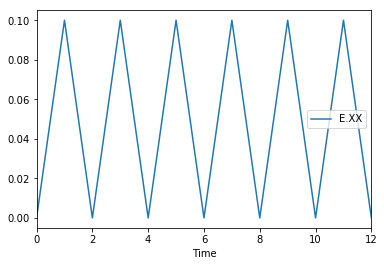

In [15]:
mps.df.plot('Time', 'E.XX')

Incidentally (and as expected) the plot shows that axial compoent of strain was cycled from 0-10% strain through a variety of deformation steps. 

Greater flexibility in plotting can be obtained by generating a `plot` object and directly plotting variables of interest

## Where to Next?

[User Defined Materials](UserMaterials.ipynb)